# LG3 Spike/Impulse Review Demo

각 컬럼의 스파이크(임펄스) 비율과 분포를 확인하고,
시계열 구간을 직접 시각화합니다.


In [128]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

RAW_EREPORT_DIR = "../../data/elec1_f2/EREPORT"
RESAMPLE_FREQ = '5min'  # set None to disable; 15min, 1H
EMA_SPAN = 6
WINDOW_LEN = 200
Z_THRESHOLD = 3.5
PERCENTILE = 99.5
FONT_SIZE = 10


In [129]:
def parse_date_from_filename(path):
    m = re.search(r"(\d{8})", os.path.basename(path))
    if not m:
        return None
    return pd.to_datetime(m.group(1), format="%Y%m%d")

def read_csv_lenient(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"[WARN] parse failed, retry with on_bad_lines='skip': {os.path.basename(path)} ({e})")
        try:
            return pd.read_csv(path, engine="python", on_bad_lines="skip")
        except Exception as e2:
            print(f"[SKIP] failed to parse: {os.path.basename(path)} ({e2})")
            return None

def load_raw_ereport(folder):
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.csv')])
    if not files:
        raise FileNotFoundError(f"No CSV files found in {folder}")
    frames = []
    for path in files:
        df = read_csv_lenient(path)
        if df is None:
            continue
        if 'Time' not in df.columns:
            continue
        file_date = parse_date_from_filename(path)
        if file_date is None:
            continue
        df['Timestamp'] = pd.to_datetime(file_date.strftime('%Y-%m-%d') + ' ' + df['Time'].astype(str), errors='coerce')
        df = df.dropna(subset=['Timestamp']).set_index('Timestamp')
        frames.append(df)
    if not frames:
        raise ValueError('No valid EREPORT files loaded.')
    return pd.concat(frames, axis=0).sort_index()


In [130]:
raw_df = load_raw_ereport(RAW_EREPORT_DIR)
num_df = raw_df.select_dtypes(include=[np.number])
if RESAMPLE_FREQ:
    num_df = num_df.resample(RESAMPLE_FREQ).mean()
print("Numeric columns:", num_df.columns.tolist())


[WARN] parse failed, retry with on_bad_lines='skip': DBG_EREPORT_20251013.csv (Error tokenizing data. C error: Expected 43 fields in line 988, saw 51
)
Numeric columns: ['Rop', 'Tin', 'Tout', 'Comp1 Hz_0', 'Comp1 Hz_1', 'Comp1 Hz_2', 'Comp1 Hz_3', 'Comp2 Hz_0', 'Comp2 Hz_1', 'Comp2 Hz_2', 'Comp2 Hz_3', 'Tcond', 'Tliqpip', 'Tevap', 'cycle', 'Power', 'HighP', 'LowP', 'error', 'SCEEV_M', 'SCEEV_S1', 'SCEEV_S2', 'SCEEV_S3', 'HEX_T_M', 'HEX_T_S1', 'HEX_T_S2', 'HEX_T_S3', 'LIQ_T_M', 'LIQ_T_S1', 'LIQ_T_S2', 'LIQ_T_S3', 'SC_IN_T_M', 'SC_IN_T_S1', 'SC_IN_T_S2', 'SC_IN_T_S3', 'LIQ_Entha', 'VAP_Entha', 'MFR_068', 'Capa_Cooling', 'Capa_Heating', 'Efficiency', 'Unnamed: 42', 'SUC_T_M', 'SUC_T_S1', 'SUC_T_S2', 'SUC_T_S3', 'LIQ_Entha_R410', 'VAP_Entha_R410', 'LIQ_Entha_R32', 'VAP_Entha_R32', 'M_SCEEV', 'ref_type', 'Unnamed: 50']


## 1) 컬럼별 스파이크 비율 (z-score / percentile)

- z-score 기준 비율
- 상위 percentile 기준 비율

컬럼 전체를 모두 출력합니다.


In [131]:
stats = []
for col in num_df.columns:
    s = num_df[col].astype(float).dropna()
    if s.empty:
        stats.append({"feature": col, "z_spike_ratio": np.nan, "p_spike_ratio": np.nan})
        continue
    mean = s.mean()
    std = s.std(ddof=0)
    if std == 0:
        z_ratio = 0.0
    else:
        z_ratio = (np.abs((s - mean) / std) > Z_THRESHOLD).mean()
    q = np.percentile(s, PERCENTILE)
    p_ratio = (s > q).mean()
    stats.append({"feature": col, "z_spike_ratio": z_ratio, "p_spike_ratio": p_ratio})

stats_df = pd.DataFrame(stats)
display(stats_df.sort_values("z_spike_ratio", ascending=False))


,feature,z_spike_ratio,p_spike_ratio
49,VAP_Entha_R32,0.061392,0.001023
47,VAP_Entha_R410,0.054570,0.005116
46,LIQ_Entha_R410,0.050477,0.005116
48,LIQ_Entha_R32,0.029332,0.005116
7,Comp2 Hz_0,0.022763,0.004886
15,Power,0.015046,0.005003
4,Comp1 Hz_1,0.014542,0.005003
3,Comp1 Hz_0,0.013999,0.004847
38,Capa_Cooling,0.013612,0.005003
37,MFR_068,0.012448,0.005003


## 2) 컬럼 분포 확인 (선택 컬럼)

- 원하는 컬럼을 바꿔가며 분포를 확인합니다.


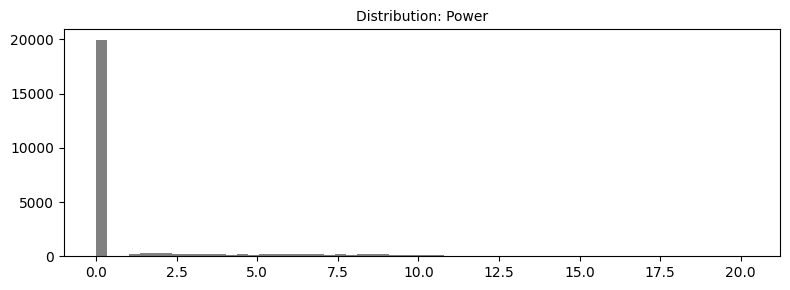

In [132]:
# FEATURE_NAME = num_df.columns[1]
FEATURE_NAME = "Power"
s = num_df[FEATURE_NAME].astype(float)

plt.figure(figsize=(8, 3))
plt.hist(s.values, bins=60, color="gray")
plt.title(f"Distribution: {FEATURE_NAME}", fontsize=FONT_SIZE)
plt.tight_layout()
plt.show()


## 3) 랜덤 구간 시계열 시각화 (선택 컬럼)

- 실행할 때마다 랜덤 구간을 보여줍니다.
- 스파이크가 실제 패턴인지 노이즈인지 판단하는 데 유용합니다.


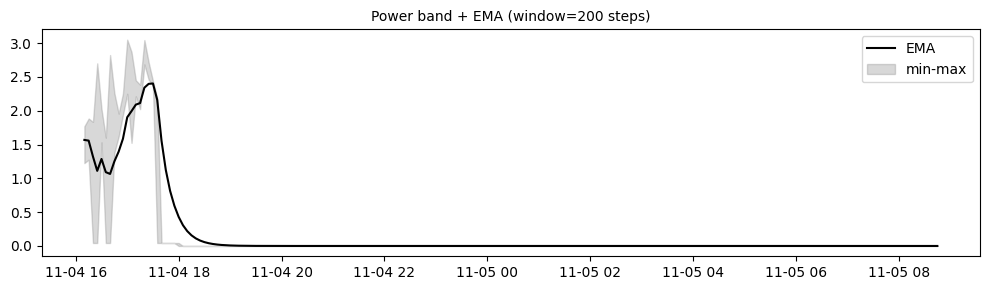

In [133]:

if FEATURE_NAME not in raw_df.columns:
    raise ValueError(f"Feature '{FEATURE_NAME}' not in raw_df")

s_raw = raw_df[FEATURE_NAME].astype(float).dropna()

if RESAMPLE_FREQ:
    agg = s_raw.resample(RESAMPLE_FREQ).agg(['min', 'max']).dropna()
    ema = s_raw.resample(RESAMPLE_FREQ).mean().ewm(span=EMA_SPAN, adjust=False).mean()
    ema = ema.reindex(agg.index)
    if len(agg) <= WINDOW_LEN:
        seg = agg
        seg_ema = ema
    else:
        start = random.randint(0, len(agg) - WINDOW_LEN)
        seg = agg.iloc[start:start + WINDOW_LEN]
        seg_ema = ema.iloc[start:start + WINDOW_LEN]

    plt.figure(figsize=(10, 3))
    plt.plot(seg_ema.index, seg_ema.values, color="black", label="EMA")
    plt.fill_between(seg.index, seg['min'], seg['max'], color="gray", alpha=0.3, label="min-max")
    plt.title(f"{FEATURE_NAME} band + EMA (window={len(seg)} steps)", fontsize=FONT_SIZE)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    if len(s_raw) <= WINDOW_LEN:
        seg = s_raw
    else:
        start = random.randint(0, len(s_raw) - WINDOW_LEN)
        seg = s_raw.iloc[start:start + WINDOW_LEN]

    plt.figure(figsize=(10, 3))
    plt.plot(seg.index, seg.values, color="black")
    plt.title(f"{FEATURE_NAME} raw window ({len(seg)} steps)", fontsize=FONT_SIZE)
    plt.tight_layout()
    plt.show()


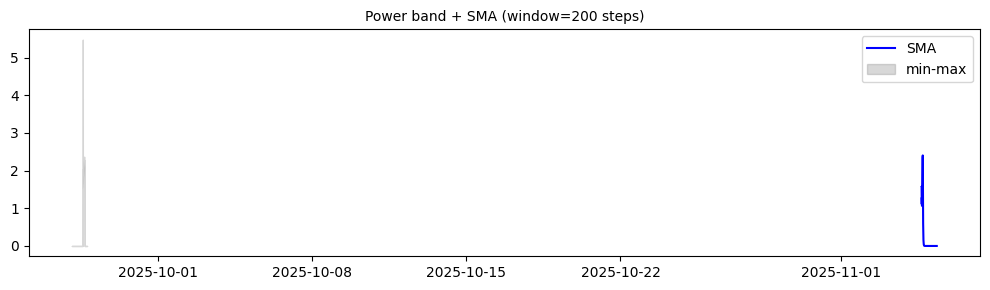

In [183]:

if RESAMPLE_FREQ:
    agg = s_raw.resample(RESAMPLE_FREQ).agg(['min', 'max']).dropna()
    sma = s_raw.resample(RESAMPLE_FREQ).mean().rolling(window=EMA_SPAN, min_periods=1).mean()
    sma = sma.reindex(agg.index)
    if len(agg) <= WINDOW_LEN:
        seg = agg
        seg_sma = sma
    else:
        start = random.randint(0, len(agg) - WINDOW_LEN)
        seg = agg.iloc[start:start + WINDOW_LEN]
        seg_sma = sma.iloc[start:start + WINDOW_LEN]

    plt.figure(figsize=(10, 3))
    plt.plot(seg_ema.index, seg_ema.values, color="blue", label="SMA")
    plt.fill_between(seg.index, seg['min'], seg['max'], color="gray", alpha=0.3, label="min-max")
    plt.title(f"{FEATURE_NAME} band + SMA (window={len(seg)} steps)", fontsize=FONT_SIZE)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    if len(s_raw) <= WINDOW_LEN:
        seg = s_raw
    else:
        start = random.randint(0, len(s_raw) - WINDOW_LEN)
        seg = s_raw.iloc[start:start + WINDOW_LEN]

    plt.figure(figsize=(10, 3))
    plt.plot(seg.index, seg.values, color="black")
    plt.title(f"{FEATURE_NAME} raw window ({len(seg)} steps)", fontsize=FONT_SIZE)
    plt.tight_layout()
    plt.show()
